# Voice Gender Recognition

Source data comes from Kory Becker of Primary Objecs: http://www.primaryobjects.com/kory-becker/

GitHub Link: https://github.com/primaryobjects/voice-gender

Full Article: http://www.primaryobjects.com/2016/06/22/identifying-the-gender-of-a-voice-using-machine-learning/

Summary:

Gender Recognition by Voice and Speech Analysis

This database was created to identify a voice as male or female, based upon acoustic properties of the voice and speech. The dataset consists of 3,168 recorded voice samples, collected from male and female speakers. The voice samples are pre-processed by acoustic analysis in R using the seewave and tuneR packages, with an analyzed frequency range of 0hz-280hz (human vocal range).

## The Dataset
The following acoustic properties of each voice are measured and included within the CSV:

* meanfreq: mean frequency (in kHz)
* sd: standard deviation of frequency
* median: median frequency (in kHz)
* Q25: first quantile (in kHz)
* Q75: third quantile (in kHz)
* IQR: interquantile range (in kHz)
* skew: skewness (see note in specprop description)
* kurt: kurtosis (see note in specprop description)
* sp.ent: spectral entropy
* sfm: spectral flatness
* mode: mode frequency
* centroid: frequency centroid (see specprop)
* peakf: peak frequency (frequency with highest energy)
* meanfun: average of fundamental frequency measured across acoustic signal
* minfun: minimum fundamental frequency measured across acoustic signal
* maxfun: maximum fundamental frequency measured across acoustic signal
* meandom: average of dominant frequency measured across acoustic signal
* mindom: minimum of dominant frequency measured across acoustic signal
* maxdom: maximum of dominant frequency measured across acoustic signal
* dfrange: range of dominant frequency measured across acoustic signal
* modindx: modulation index. Calculated as the accumulated absolute difference between adjacent measurements of fundamental frequencies divided by the frequency range
* label: male or female

In [1]:
# Dependencies
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
voice = pd.read_csv('Resources/voice.csv')
voice.head()

meanfreq        sd    median       Q25       Q75       IQR       skew  \
0  0.059781  0.064241  0.032027  0.015071  0.090193  0.075122  12.863462   
1  0.066009  0.067310  0.040229  0.019414  0.092666  0.073252  22.423285   
2  0.077316  0.083829  0.036718  0.008701  0.131908  0.123207  30.757155   
3  0.151228  0.072111  0.158011  0.096582  0.207955  0.111374   1.232831   
4  0.135120  0.079146  0.124656  0.078720  0.206045  0.127325   1.101174   

          kurt    sp.ent       sfm  ...    centroid   meanfun    minfun  \
0   274.402906  0.893369  0.491918  ...    0.059781  0.084279  0.015702   
1   634.613855  0.892193  0.513724  ...    0.066009  0.107937  0.015826   
2  1024.927705  0.846389  0.478905  ...    0.077316  0.098706  0.015656   
3     4.177296  0.963322  0.727232  ...    0.151228  0.088965  0.017798   
4     4.333713  0.971955  0.783568  ...    0.135120  0.106398  0.016931   

     maxfun   meandom    mindom    maxdom   dfrange   modindx  label  
0  0.275862  0.007812  0.007812  0.007812  0.000000  0.000000   male  
1  0.250000  0.009014  0.007812  0.054688  0.046875  0.052632   male  
2  0.271186  0.007990  0.007812  0.015625  0.007812  0.046512   male  
3  0.250000  0.201497  0.007812  0.562500  0.554688  0.247119   male  
4  0.266667  0.712812  0.007812  5.484375  5.476562  0.208274   male  

[5 rows x 21 columns]

## Data Pre-Processing

In [217]:
#Split dataset into audio data and gender label
X = voice.drop("label", axis=1)
y = voice["label"]
print(X.shape, y.shape)

(3168, 20) (3168,)


In [218]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.utils import to_categorical

#Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y, test_size=.25)

#Standardize the training and testing data set
X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [219]:
#Encode Labels for the Neural Network

#Encode Female/Male labels to numerical
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

#Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

# Create a Logistic Regression Model Using Scikit-Learn

In [220]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()

#Fit the logistic regression model to our training data
logistic.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [221]:
#Check our accuracy score on the testing data
print(f"Training Data Score: {logistic.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {logistic.score(X_test_scaled, y_test)}")

Training Data Score: 0.9730639730639731
Testing Data Score: 0.9772727272727273


### Make Predictions Using the Logistic Regression Model

In [222]:
predictions = logistic.predict(X_test[:10])
pd.DataFrame({"Prediction": predictions,"Actual": y_test[:10]}).reset_index(drop=True)

Actual Prediction
0  female     female
1  female     female
2    male     female
3  female     female
4    male     female
5    male     female
6  female     female
7  female     female
8    male     female
9    male     female

# Create a Deep Learning Model Using Keras

In [223]:
from keras.models import Sequential
from keras.layers import Dense

# Create the model with two layers
model = Sequential()
model.add(Dense(units = 100, activation = 'relu', input_dim = 20))
model.add(Dense(units = 100, activation = 'relu'))
model.add(Dense(units = 2, activation = 'softmax'))

In [224]:
# Compile and fit the model
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.fit(X_train_scaled, y_train_categorical, epochs = 200, shuffle = 'true', verbose = 2)

Epoch 1/200
 - 1s - loss: 0.2553 - acc: 0.9032
Epoch 2/200
 - 0s - loss: 0.0917 - acc: 0.9705
Epoch 3/200
 - 0s - loss: 0.0741 - acc: 0.9731
Epoch 4/200
 - 0s - loss: 0.0633 - acc: 0.9802
Epoch 5/200
 - 0s - loss: 0.0599 - acc: 0.9819
Epoch 6/200
 - 0s - loss: 0.0534 - acc: 0.9811
Epoch 7/200
 - 0s - loss: 0.0511 - acc: 0.9806
Epoch 8/200
 - 0s - loss: 0.0461 - acc: 0.9853
Epoch 9/200
 - 0s - loss: 0.0432 - acc: 0.9840
Epoch 10/200
 - 0s - loss: 0.0398 - acc: 0.9844
Epoch 11/200
 - 0s - loss: 0.0395 - acc: 0.9832
Epoch 12/200
 - 0s - loss: 0.0333 - acc: 0.9861
Epoch 13/200
 - 0s - loss: 0.0317 - acc: 0.9870
Epoch 14/200
 - 0s - loss: 0.0303 - acc: 0.9891
Epoch 15/200
 - 0s - loss: 0.0319 - acc: 0.9878
Epoch 16/200
 - 0s - loss: 0.0288 - acc: 0.9882
Epoch 17/200
 - 0s - loss: 0.0264 - acc: 0.9878
Epoch 18/200
 - 0s - loss: 0.0212 - acc: 0.9916
Epoch 19/200
 - 0s - loss: 0.0210 - acc: 0.9920
Epoch 20/200
 - 0s - loss: 0.0199 - acc: 0.9924
Epoch 21/200
 - 0s - loss: 0.0164 - acc: 0.9954
E

Epoch 163/200
 - 0s - loss: 4.6815e-05 - acc: 1.0000
Epoch 164/200
 - 0s - loss: 4.7111e-05 - acc: 1.0000
Epoch 165/200
 - 0s - loss: 4.4503e-05 - acc: 1.0000
Epoch 166/200
 - 0s - loss: 5.1397e-05 - acc: 1.0000
Epoch 167/200
 - 0s - loss: 5.0638e-05 - acc: 1.0000
Epoch 168/200
 - 0s - loss: 3.7475e-05 - acc: 1.0000
Epoch 169/200
 - 0s - loss: 3.7302e-05 - acc: 1.0000
Epoch 170/200
 - 0s - loss: 3.6925e-05 - acc: 1.0000
Epoch 171/200
 - 0s - loss: 3.5134e-05 - acc: 1.0000
Epoch 172/200
 - 0s - loss: 3.5822e-05 - acc: 1.0000
Epoch 173/200
 - 0s - loss: 3.4098e-05 - acc: 1.0000
Epoch 174/200
 - 0s - loss: 2.9565e-05 - acc: 1.0000
Epoch 175/200
 - 0s - loss: 2.6862e-05 - acc: 1.0000
Epoch 176/200
 - 0s - loss: 2.7059e-05 - acc: 1.0000
Epoch 177/200
 - 0s - loss: 2.4403e-05 - acc: 1.0000
Epoch 178/200
 - 0s - loss: 2.4668e-05 - acc: 1.0000
Epoch 179/200
 - 0s - loss: 2.5044e-05 - acc: 1.0000
Epoch 180/200
 - 0s - loss: 2.2393e-05 - acc: 1.0000
Epoch 181/200
 - 0s - loss: 2.1898e-05 - acc: 

In [225]:
#Check our model on the testing data
model_loss, model_accuracy = model.evaluate(X_test_scaled, y_test_categorical, verbose=2)
print(f"Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

Neural Network - Loss: 0.09626276412217581, Accuracy: 0.9861111111111112


In [226]:
print(model.history.history.keys())

dict_keys(['loss', 'acc'])


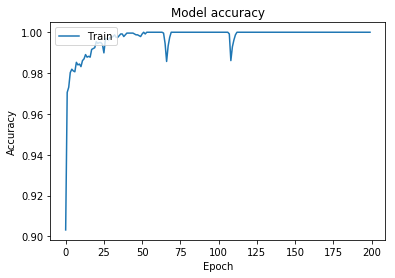

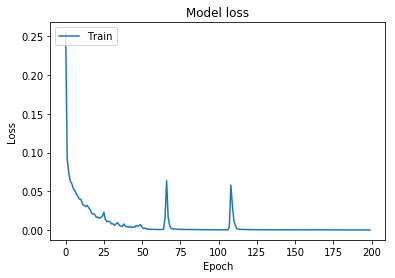

In [227]:
# Plot training accuracy values
plt.plot(model.history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training loss values
plt.plot(model.history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Make Predictions Using the Neural Network

In [228]:
#Check the first 10 predictions vs the actual labels using our logistic regression model

encoded_predictions = model.predict_classes(X_test_scaled[:10])
prediction_labels = label_encoder.inverse_transform(encoded_predictions)

pd.DataFrame({"Neural Network Prediction": prediction_labels, "Actual": y_test[:10]}).reset_index(drop=True)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Actual Neural Network Prediction
0  female                    female
1  female                    female
2    male                      male
3  female                    female
4    male                      male
5    male                      male
6  female                      male
7  female                    female
8    male                      male
9    male                      male